# Dadi Parameter Analysis: Best Fit vs Ground Truth

This notebook analyzes the dadi optimization results from split migration experiments, comparing best fit parameters against ground truth values and visualizing parameter distributions across replicates.

## Import Required Libraries

Import necessary libraries for data manipulation and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from pathlib import Path
import glob
from scipy import stats

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Set Up Data Paths

Define paths to the experiment directories containing simulations and results.

In [2]:
# Define base paths
base_path = Path('/home/akapoor/kernlab/Infer_Demography/experiments/split_migration')
simulations_path = base_path / 'simulations'
runs_path = base_path / 'runs'

print(f"Base path: {base_path}")
print(f"Simulations path: {simulations_path}")
print(f"Runs path: {runs_path}")

# Check if paths exist
print(f"\nPaths exist:")
print(f"Simulations: {simulations_path.exists()}")
print(f"Runs: {runs_path.exists()}")

Base path: /home/akapoor/kernlab/Infer_Demography/experiments/split_migration
Simulations path: /home/akapoor/kernlab/Infer_Demography/experiments/split_migration/simulations
Runs path: /home/akapoor/kernlab/Infer_Demography/experiments/split_migration/runs

Paths exist:
Simulations: True
Runs: True


## Load Simulation Data and Ground Truth

Read ground truth parameter values from the simulations directory structure.

In [3]:
def load_ground_truth_parameters():
    """Load ground truth parameters from simulation directories 0-9."""
    ground_truth = {}
    
    # Iterate through simulation directories (0-9 only)
    sim_ids = [str(i) for i in range(10)]  # Only simulations 0-9
    
    for sim_id in sim_ids:
        sim_dir = simulations_path / sim_id
        if sim_dir.is_dir():
            param_file = sim_dir / 'sampled_params.pkl'
            
            if param_file.exists():
                try:
                    with open(param_file, 'rb') as f:
                        params = pickle.load(f)
                    ground_truth[sim_id] = params
                    print(f"Loaded ground truth for simulation {sim_id}")
                except Exception as e:
                    print(f"Error loading {param_file}: {e}")
            else:
                print(f"Parameter file not found: {param_file}")
        else:
            print(f"Simulation directory not found: {sim_dir}")
    
    return ground_truth

# Load ground truth parameters for simulations 0-9
ground_truth_params = load_ground_truth_parameters()

# Display structure of ground truth data
if ground_truth_params:
    first_sim = list(ground_truth_params.keys())[0]
    print(f"\nExample parameters for simulation {first_sim}:")
    for key, value in ground_truth_params[first_sim].items():
        print(f"  {key}: {value}")
    
    print(f"\nLoaded ground truth for simulations: {sorted(ground_truth_params.keys())}")
else:
    print("No ground truth parameters loaded!")

Loaded ground truth for simulation 0
Loaded ground truth for simulation 1
Loaded ground truth for simulation 2
Loaded ground truth for simulation 3
Loaded ground truth for simulation 4
Loaded ground truth for simulation 5
Loaded ground truth for simulation 6
Loaded ground truth for simulation 7
Loaded ground truth for simulation 8
Loaded ground truth for simulation 9

Example parameters for simulation 0:
  N0: 6001.880280737147
  N1: 23878.629871911482
  N2: 21631.39026918877
  m12: 7.502918770584755e-05
  m21: 8.712157593790558e-05
  t_split: 1733.1729735582999

Loaded ground truth for simulations: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Load Dadi Best Fit Results

Load the dadi optimization results for each run, including parameter estimates and likelihood values.

In [4]:
def load_dadi_results():
    """Load dadi best fit results from run directories for simulations 0-9."""
    dadi_results = {}
    
    # Focus on simulations 0-9 only
    target_simulations = set(str(i) for i in range(10))
    
    # Search for dadi result files in run directories
    run_dirs = sorted(runs_path.glob('run_*_*'))
    
    print(f"Found {len(run_dirs)} run directories")
    print("Looking for results from simulations 0-9...")
    
    for run_dir in run_dirs:
        if run_dir.is_dir():
            run_name = run_dir.name
            
            # Parse run name to get simulation ID
            parts = run_name.split('_')
            if len(parts) >= 3:
                sim_id = parts[1]
                rep_id = parts[2]
                
                # Only process simulations 0-9
                if sim_id not in target_simulations:
                    continue
                
                # Look for dadi output files
                possible_files = [
                    run_dir / 'inferences/dadi/fit_params.pkl',
                    run_dir / 'inferences/dadi/best_fit.pkl',
                    run_dir / 'optimization_results.pkl',
                    run_dir / 'dadi_results.pkl',
                    run_dir / 'results.pkl'
                ]
                
                result_file = None
                for pf in possible_files:
                    if pf.exists():
                        result_file = pf
                        break
                
                if result_file:
                    try:
                        with open(result_file, 'rb') as f:
                            results = pickle.load(f)
                        
                        if sim_id not in dadi_results:
                            dadi_results[sim_id] = {}
                        
                        dadi_results[sim_id][rep_id] = {
                            'results': results,
                            'file': result_file
                        }
                        
                    except Exception as e:
                        print(f"Error loading {result_file}: {e}")
                else:
                    # Check what files are actually in the directory
                    files = list(run_dir.glob('*'))
                    if len(files) > 0 and sim_id in ['0', '1', '2']:  # Only show for first few sims
                        print(f"No recognized result file in {run_name}. Available files: {[f.name for f in files[:5]]}")
    
    return dadi_results

# Load dadi results for simulations 0-9
dadi_results = load_dadi_results()

# Display summary of loaded results
print(f"\nLoaded dadi results for simulations 0-9:")
for sim_id in sorted(dadi_results.keys(), key=int):
    print(f"  Simulation {sim_id}: {len(dadi_results[sim_id])} replicates")

# Show structure of first result if available
if dadi_results:
    first_sim = sorted(dadi_results.keys(), key=int)[0]
    first_rep = list(dadi_results[first_sim].keys())[0]
    first_result = dadi_results[first_sim][first_rep]['results']
    print(f"\nExample result structure for sim {first_sim}, rep {first_rep}:")
    if isinstance(first_result, dict):
        for key in first_result.keys():
            print(f"  {key}: {type(first_result[key])}")
    else:
        print(f"  Result type: {type(first_result)}")

Found 100000 run directories
Looking for results from simulations 0-9...

Loaded dadi results for simulations 0-9:
  Simulation 0: 100 replicates
  Simulation 1: 100 replicates
  Simulation 2: 100 replicates
  Simulation 3: 100 replicates
  Simulation 4: 100 replicates
  Simulation 5: 100 replicates
  Simulation 6: 100 replicates
  Simulation 7: 100 replicates
  Simulation 8: 100 replicates
  Simulation 9: 100 replicates

Example result structure for sim 0, rep 0:
  mode: <class 'str'>
  best_params: <class 'dict'>
  best_ll: <class 'float'>
  param_order: <class 'list'>
  fixed_params: <class 'dict'>

Loaded dadi results for simulations 0-9:
  Simulation 0: 100 replicates
  Simulation 1: 100 replicates
  Simulation 2: 100 replicates
  Simulation 3: 100 replicates
  Simulation 4: 100 replicates
  Simulation 5: 100 replicates
  Simulation 6: 100 replicates
  Simulation 7: 100 replicates
  Simulation 8: 100 replicates
  Simulation 9: 100 replicates

Example result structure for sim 0, re

## Explore Data Structure

Let's examine the actual file structure to understand how the data is organized.

In [5]:
# Let's explore the actual directory structure for simulations 0-9
print("Examining run directory structure for simulations 0-9...")

# Check run directories for simulations 0-9 only
target_sims = set(str(i) for i in range(10))
sample_runs = [d for d in runs_path.glob('run_*_*') 
               if len(d.name.split('_')) >= 3 and d.name.split('_')[1] in target_sims][:5]

for run_dir in sample_runs:
    print(f"\n{run_dir.name}:")
    files = sorted(run_dir.glob('**/*'), key=lambda x: str(x))  # Recursive glob
    for f in files[:10]:  # Limit output
        if f.is_file():
            size = f.stat().st_size
            rel_path = f.relative_to(run_dir)
            print(f"  {rel_path} ({size} bytes)")
        else:
            rel_path = f.relative_to(run_dir)
            print(f"  {rel_path}/ (directory)")

# Also check simulation directory structure for simulations 0-9
print("\n\nExamining simulation directory structure for simulations 0-9...")
sim_dirs = [simulations_path / str(i) for i in range(10) if (simulations_path / str(i)).exists()]

for sim_dir in sim_dirs[:3]:  # Show first 3
    print(f"\n{sim_dir.name}:")
    files = sorted(sim_dir.glob('*'))
    for f in files:
        if f.is_file():
            size = f.stat().st_size
            print(f"  {f.name} ({size} bytes)")
        else:
            print(f"  {f.name}/ (directory)")

Examining run directory structure for simulations 0-9...

run_4_44:
  inferences/ (directory)
  inferences/dadi/ (directory)
  inferences/dadi/best_fit.pkl (205 bytes)
  inferences/dadi/fit_params.pkl (205 bytes)
  inferences/dadi/profiles_grid.png (120534 bytes)
  inferences/moments/ (directory)
  inferences/moments/best_fit.pkl (208 bytes)
  inferences/moments/fit_params.pkl (208 bytes)
  inferences/moments/profiles_grid.png (127648 bytes)

run_3_40:
  inferences/ (directory)
  inferences/dadi/ (directory)
  inferences/dadi/best_fit.pkl (205 bytes)
  inferences/dadi/fit_params.pkl (205 bytes)
  inferences/dadi/profiles_grid.png (129089 bytes)
  inferences/moments/ (directory)
  inferences/moments/best_fit.pkl (208 bytes)
  inferences/moments/fit_params.pkl (208 bytes)
  inferences/moments/profiles_grid.png (133597 bytes)

run_9_35:
  inferences/ (directory)
  inferences/dadi/ (directory)
  inferences/dadi/best_fit.pkl (205 bytes)
  inferences/dadi/fit_params.pkl (205 bytes)
  inferen

## Create Data Loading Functions (Updated)

Based on the actual file structure, let's create more specific loading functions.

In [6]:
def extract_parameters_from_results(results_data):
    """Extract parameter values from dadi results data structure."""
    params = {}
    
    # This function will need to be adapted based on your actual dadi output format
    # Common dadi result formats include:
    
    if isinstance(results_data, dict):
        # If it's a dictionary, look for common parameter keys
        param_keys = ['best_params', 'optimal_params', 'parameters', 'theta', 'params']
        
        for key in param_keys:
            if key in results_data:
                params = results_data[key]
                break
        
        # Also look for likelihood
        ll_keys = ['best_lls', 'likelihood', 'll', 'log_likelihood']
        for key in ll_keys:
            if key in results_data:
                params['log_likelihood'] = results_data[key]
                break
    
    elif isinstance(results_data, (list, tuple, np.ndarray)):
        # If it's an array, assume it's parameter values
        # You'll need to map these to parameter names based on your model
        param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']  # Adjust based on your model
        
        if len(results_data) == len(param_names):
            params = dict(zip(param_names, results_data))
    
    return params

def create_comparison_dataframe(ground_truth_params, dadi_results):
    """Create a DataFrame comparing ground truth vs estimated parameters."""
    comparison_data = []
    
    for sim_id in ground_truth_params.keys():
        if sim_id in dadi_results:
            gt_params = ground_truth_params[sim_id]
            
            for rep_id, rep_data in dadi_results[sim_id].items():
                est_params = extract_parameters_from_results(rep_data['results'])
                
                # Create a row for each parameter
                for param_name in gt_params.keys():
                    if param_name in est_params:
                        comparison_data.append({
                            'simulation': sim_id,
                            'replicate': rep_id,
                            'parameter': param_name,
                            'ground_truth': gt_params[param_name],
                            'estimated': est_params[param_name],
                            'relative_error': (est_params[param_name] - gt_params[param_name]) / gt_params[param_name] if gt_params[param_name] != 0 else np.nan
                        })
    
    return pd.DataFrame(comparison_data)

# Try to create the comparison DataFrame
if ground_truth_params and dadi_results:
    df_comparison = create_comparison_dataframe(ground_truth_params, dadi_results)
    print(f"Created comparison DataFrame with {len(df_comparison)} rows")
    print(f"Parameters found: {df_comparison['parameter'].unique()}")
    print(f"\nFirst few rows:")
    print(df_comparison.head())
else:
    print("Cannot create comparison DataFrame - missing ground truth or dadi results")

Created comparison DataFrame with 6000 rows
Parameters found: ['N0' 'N1' 'N2' 'm12' 'm21' 't_split']

First few rows:
  simulation replicate parameter  ground_truth     estimated  relative_error
0          0         0        N0   6001.880281   6243.288182        0.040222
1          0         0        N1  23878.629872  26702.287192        0.118250
2          0         0        N2  21631.390269  28672.213342        0.325491
3          0         0       m12      0.000075      0.000001       -0.986602
4          0         0       m21      0.000087      0.000001       -0.987506


## Plot Best Fit vs Ground Truth Comparison

Create scatter plots comparing estimated parameters against true parameter values.

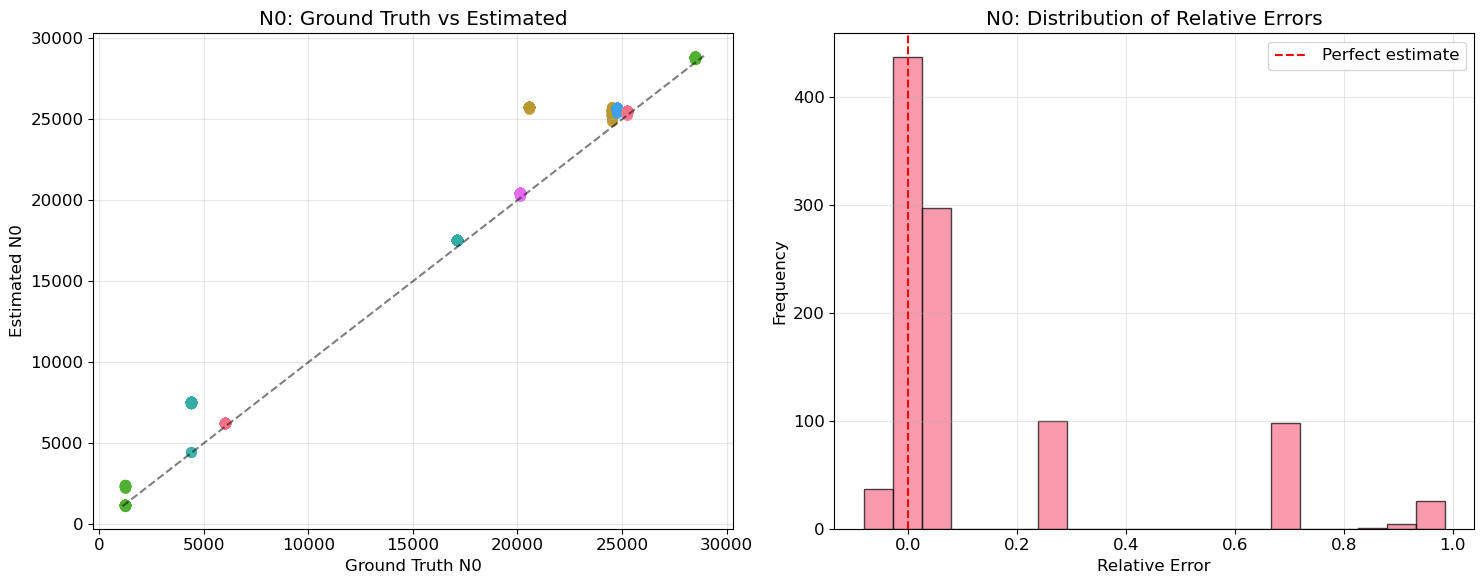


Summary for N0:
  Mean relative error: 0.1389
  Std relative error: 0.2538
  Correlation coefficient: 0.9858


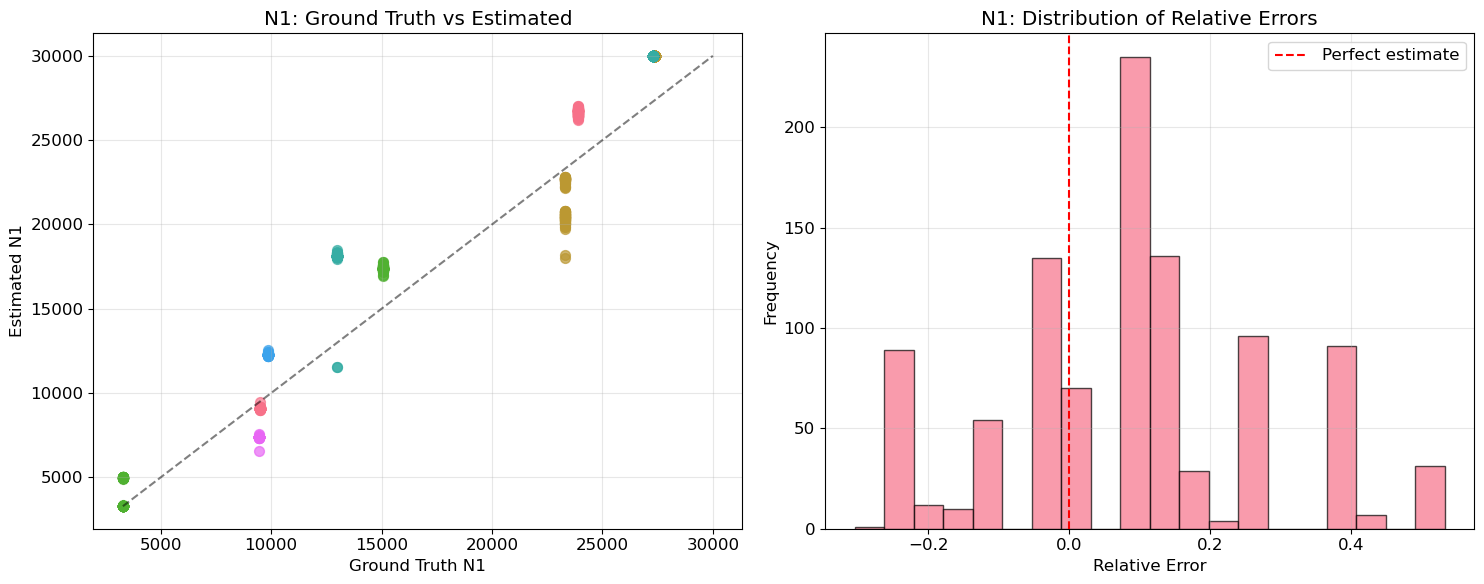


Summary for N1:
  Mean relative error: 0.0909
  Std relative error: 0.1830
  Correlation coefficient: 0.9687


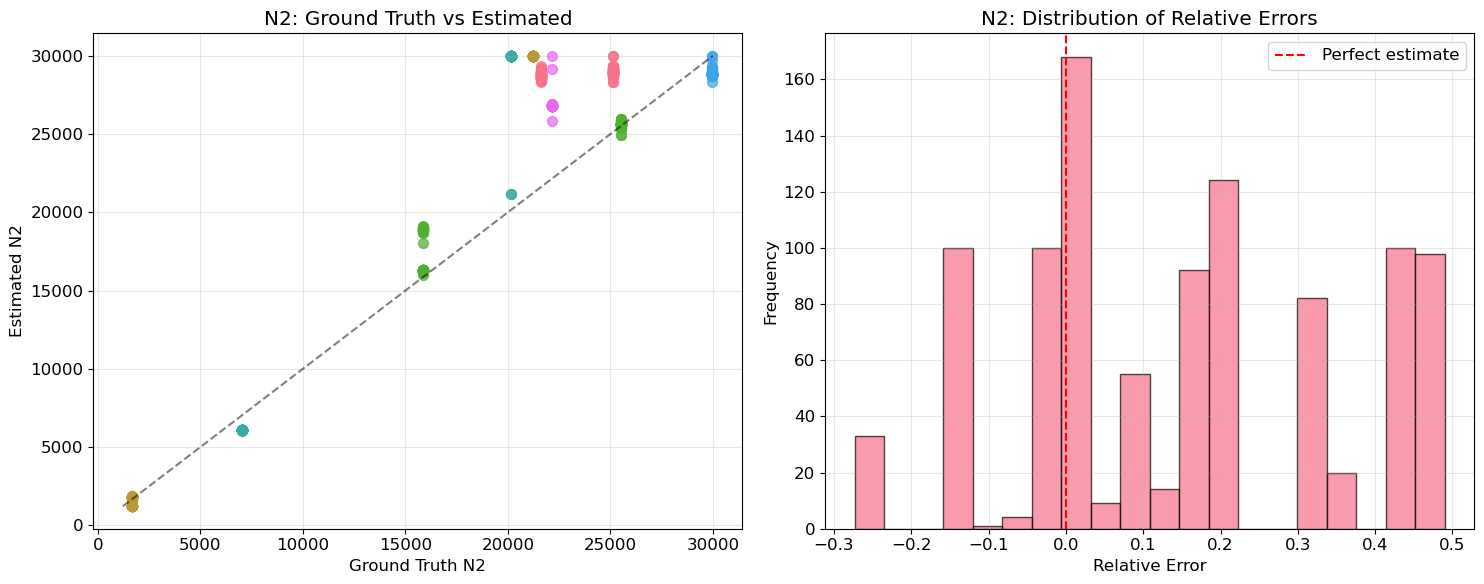


Summary for N2:
  Mean relative error: 0.1463
  Std relative error: 0.2070
  Correlation coefficient: 0.9253


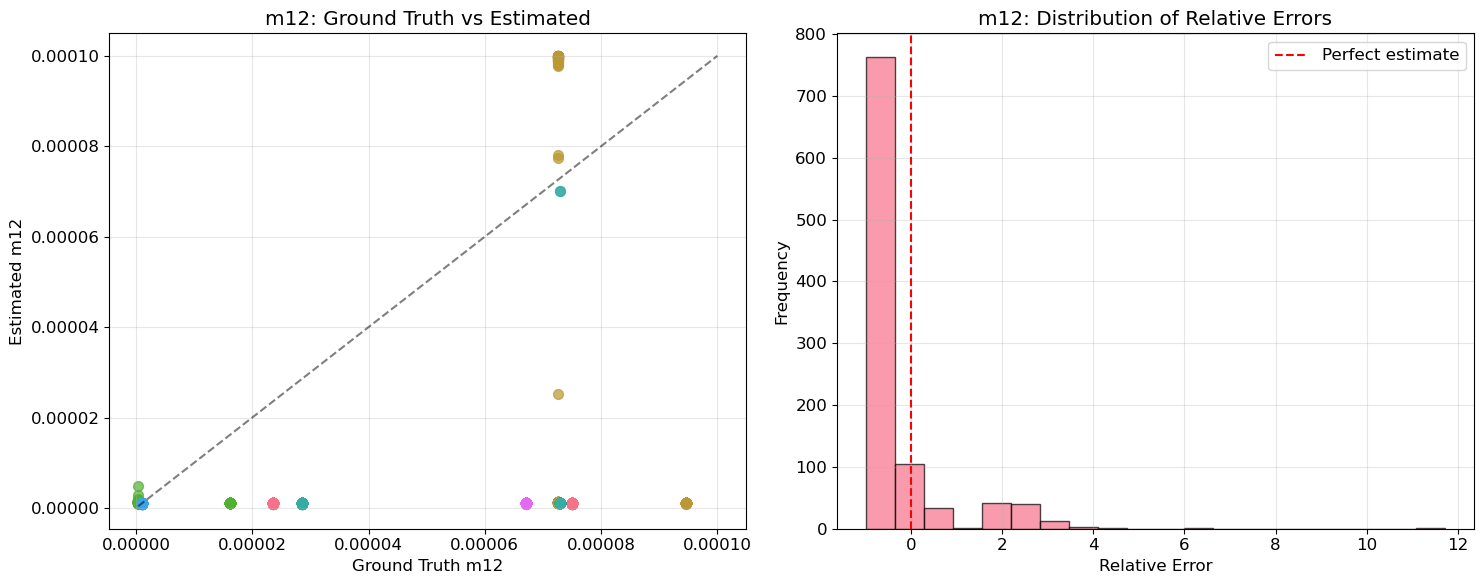


Summary for m12:
  Mean relative error: -0.4840
  Std relative error: 1.1143
  Correlation coefficient: 0.1622


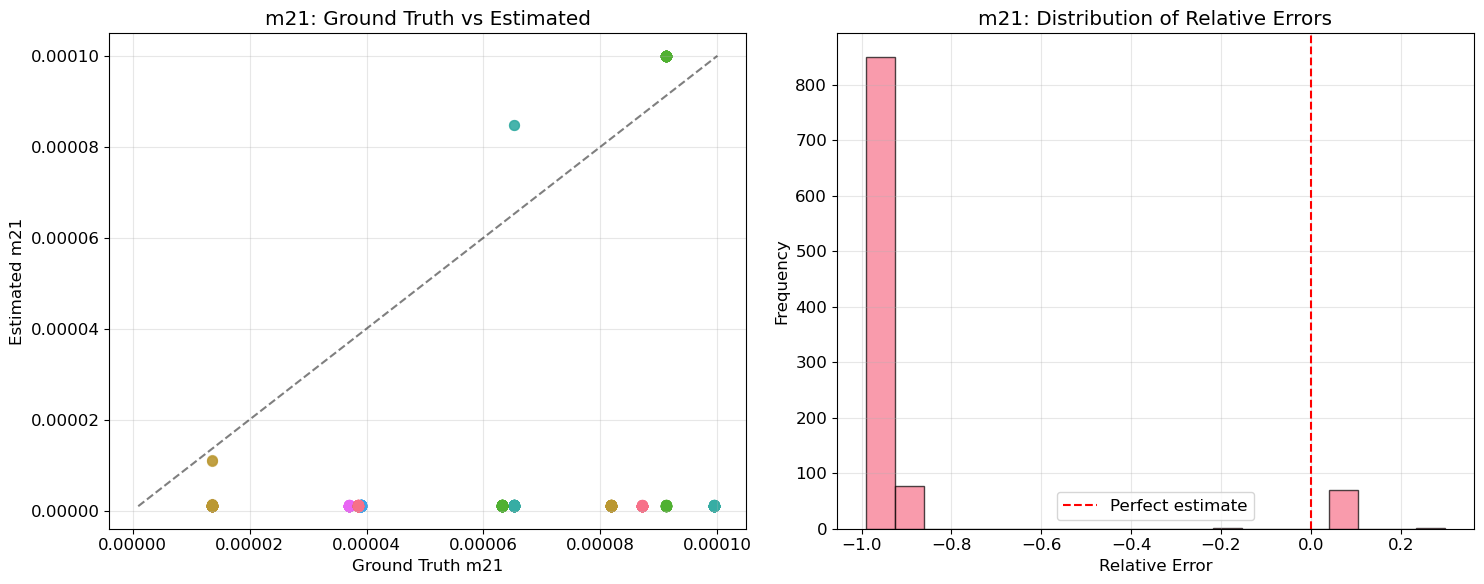


Summary for m21:
  Mean relative error: -0.8968
  Std relative error: 0.2793
  Correlation coefficient: 0.2941


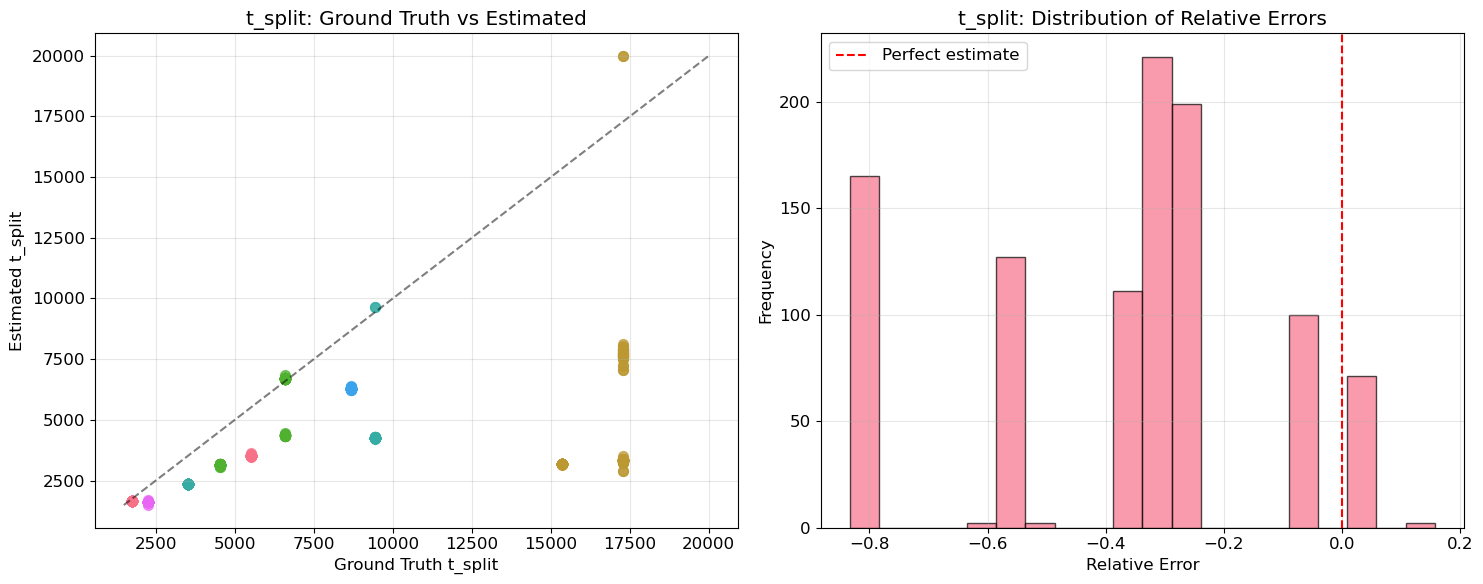


Summary for t_split:
  Mean relative error: -0.3729
  Std relative error: 0.2420
  Correlation coefficient: 0.4406


In [7]:
def plot_parameter_comparison(df, parameter_name):
    """Plot ground truth vs estimated values for a specific parameter."""
    param_data = df[df['parameter'] == parameter_name]
    
    if len(param_data) == 0:
        print(f"No data found for parameter {parameter_name}")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot: Ground truth vs Estimated
    ax1 = axes[0]
    
    # Color by simulation
    for sim_id in param_data['simulation'].unique():
        sim_data = param_data[param_data['simulation'] == sim_id]
        ax1.scatter(sim_data['ground_truth'], sim_data['estimated'], 
                   label=f'Sim {sim_id}', alpha=0.7, s=50)
    
    # Add identity line
    min_val = min(param_data['ground_truth'].min(), param_data['estimated'].min())
    max_val = max(param_data['ground_truth'].max(), param_data['estimated'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Identity line')
    
    ax1.set_xlabel(f'Ground Truth {parameter_name}')
    ax1.set_ylabel(f'Estimated {parameter_name}')
    ax1.set_title(f'{parameter_name}: Ground Truth vs Estimated')
    # ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Relative error histogram
    ax2 = axes[1]
    ax2.hist(param_data['relative_error'].dropna(), bins=20, alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', label='Perfect estimate')
    ax2.set_xlabel('Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{parameter_name}: Distribution of Relative Errors')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for {parameter_name}:")
    print(f"  Mean relative error: {param_data['relative_error'].mean():.4f}")
    print(f"  Std relative error: {param_data['relative_error'].std():.4f}")
    print(f"  Correlation coefficient: {param_data['ground_truth'].corr(param_data['estimated']):.4f}")

# Plot comparisons for all parameters
if 'df_comparison' in locals() and not df_comparison.empty:
    for param in df_comparison['parameter'].unique():
        plot_parameter_comparison(df_comparison, param)
else:
    print("No comparison data available for plotting")

## Create Parameter Histograms for Each Simulation

Generate histograms showing the distribution of best fit parameters across replicates for each simulation.

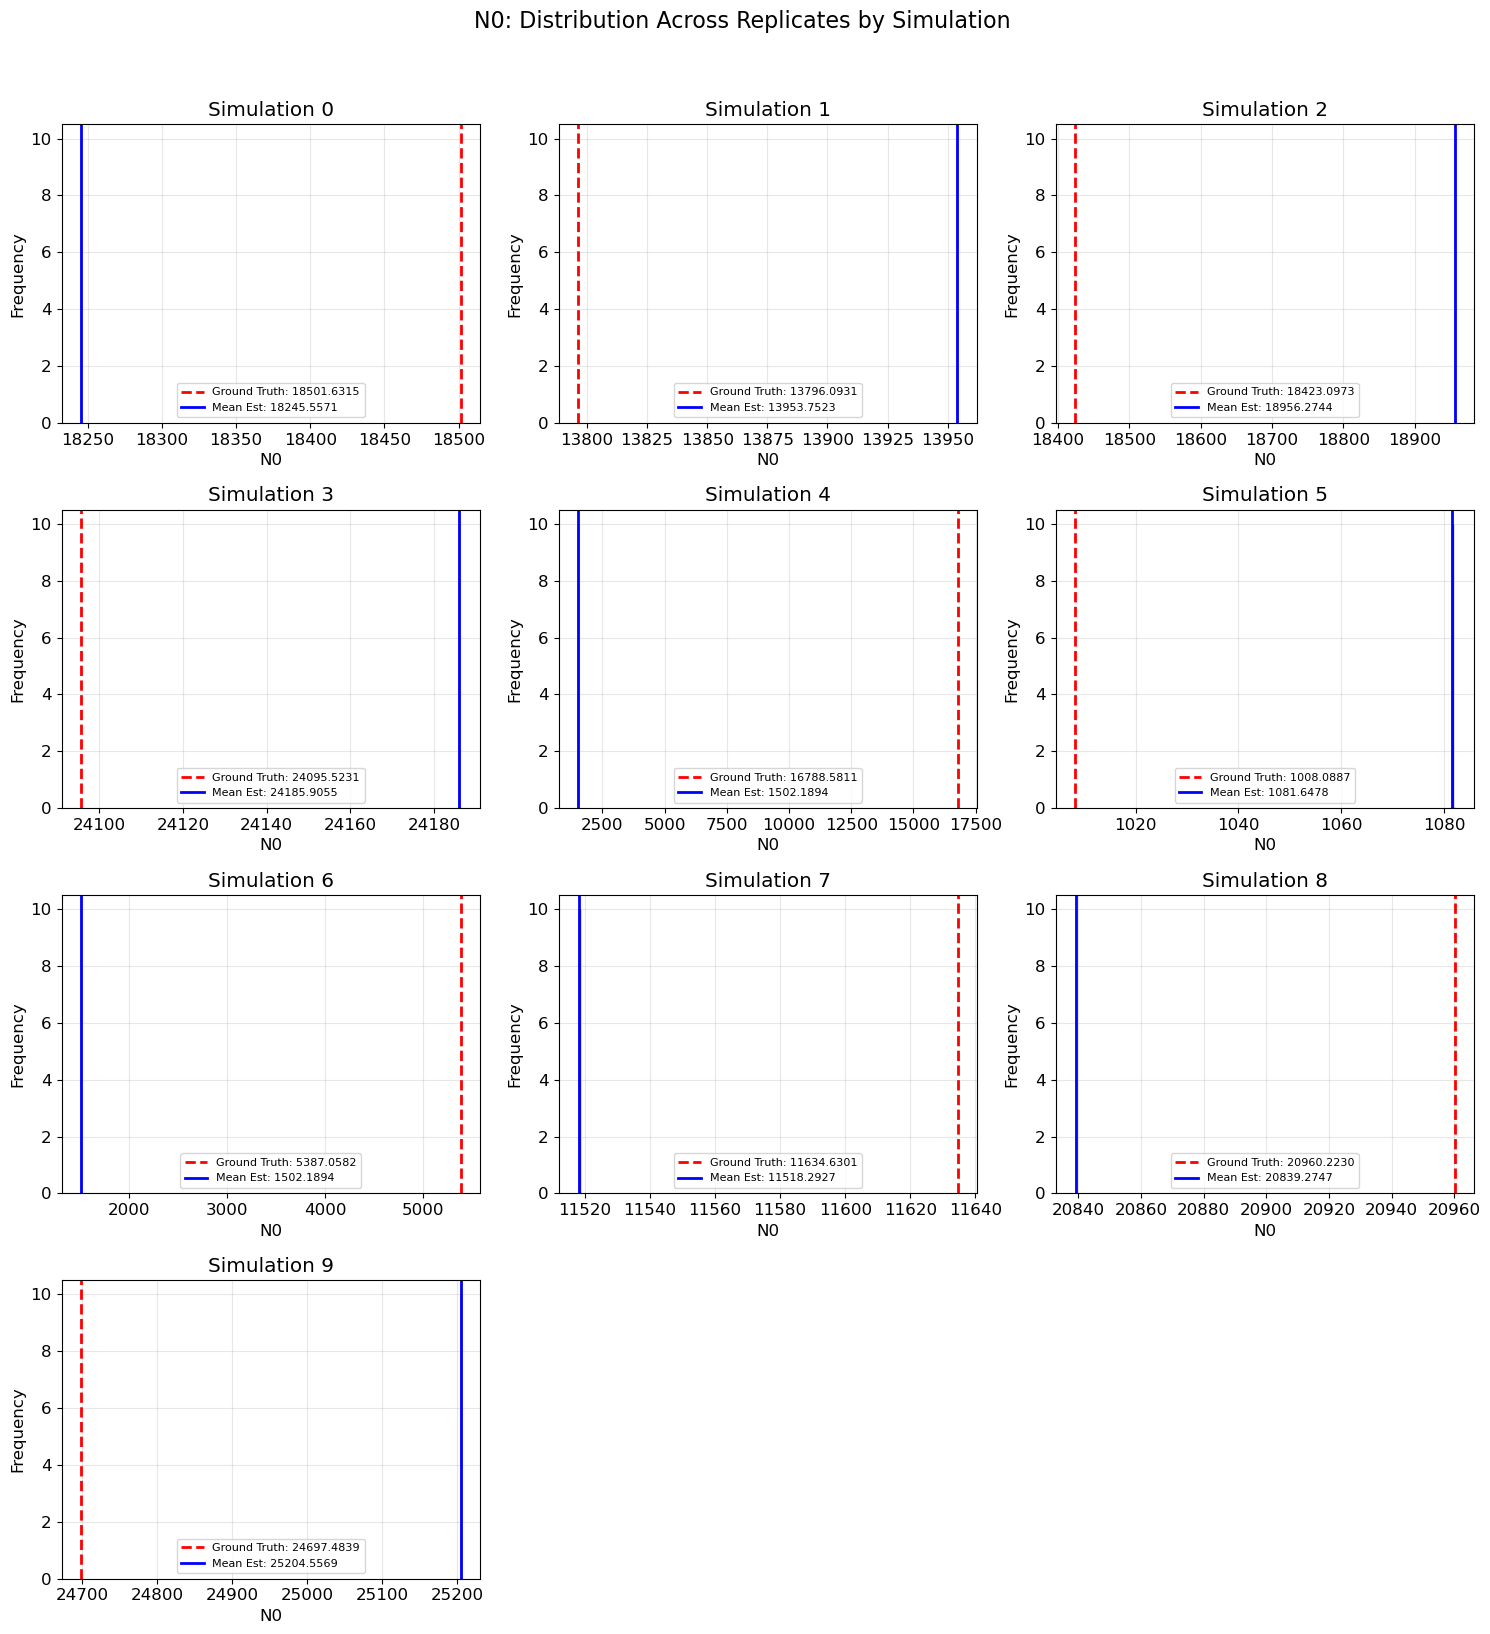

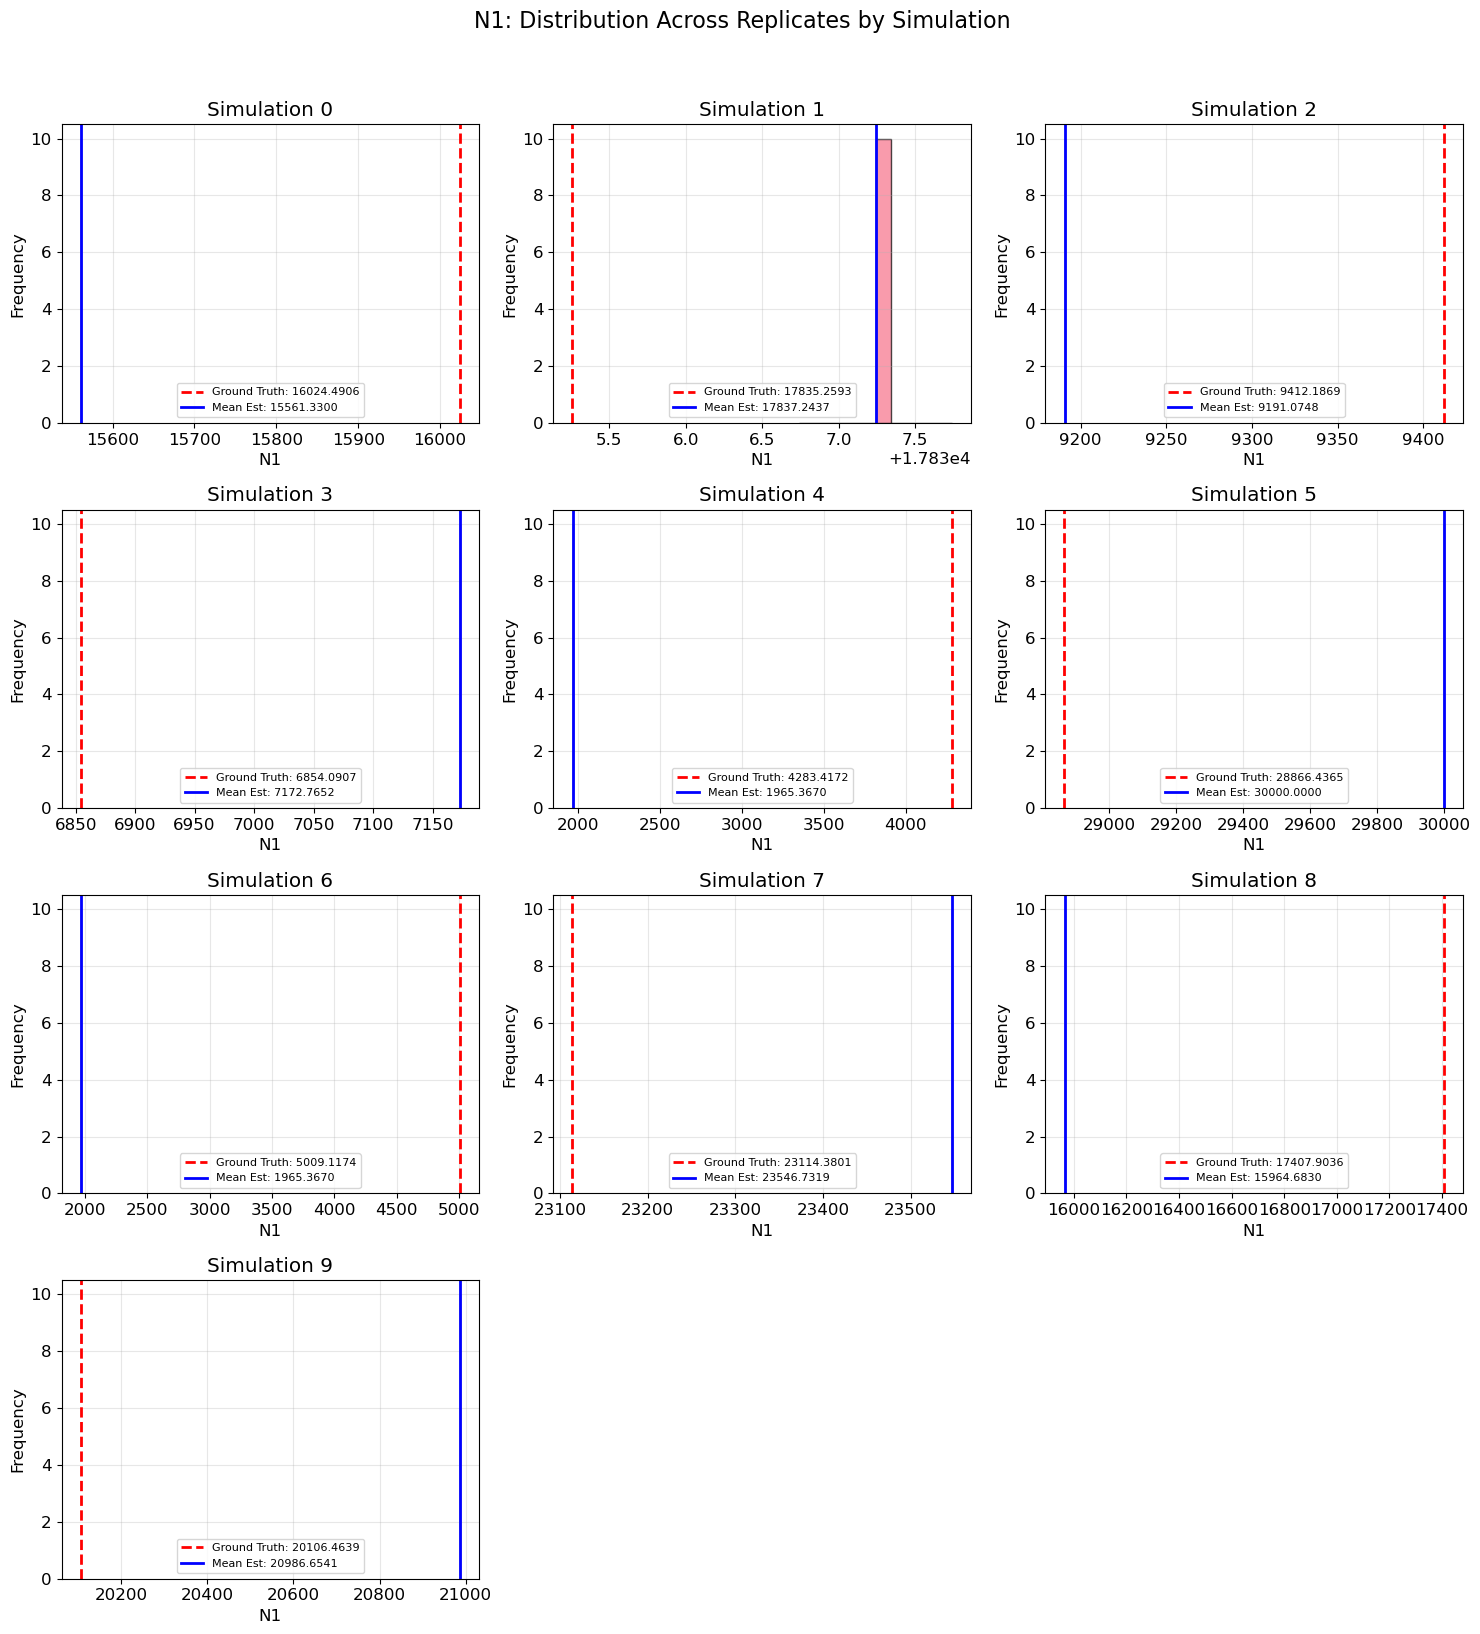

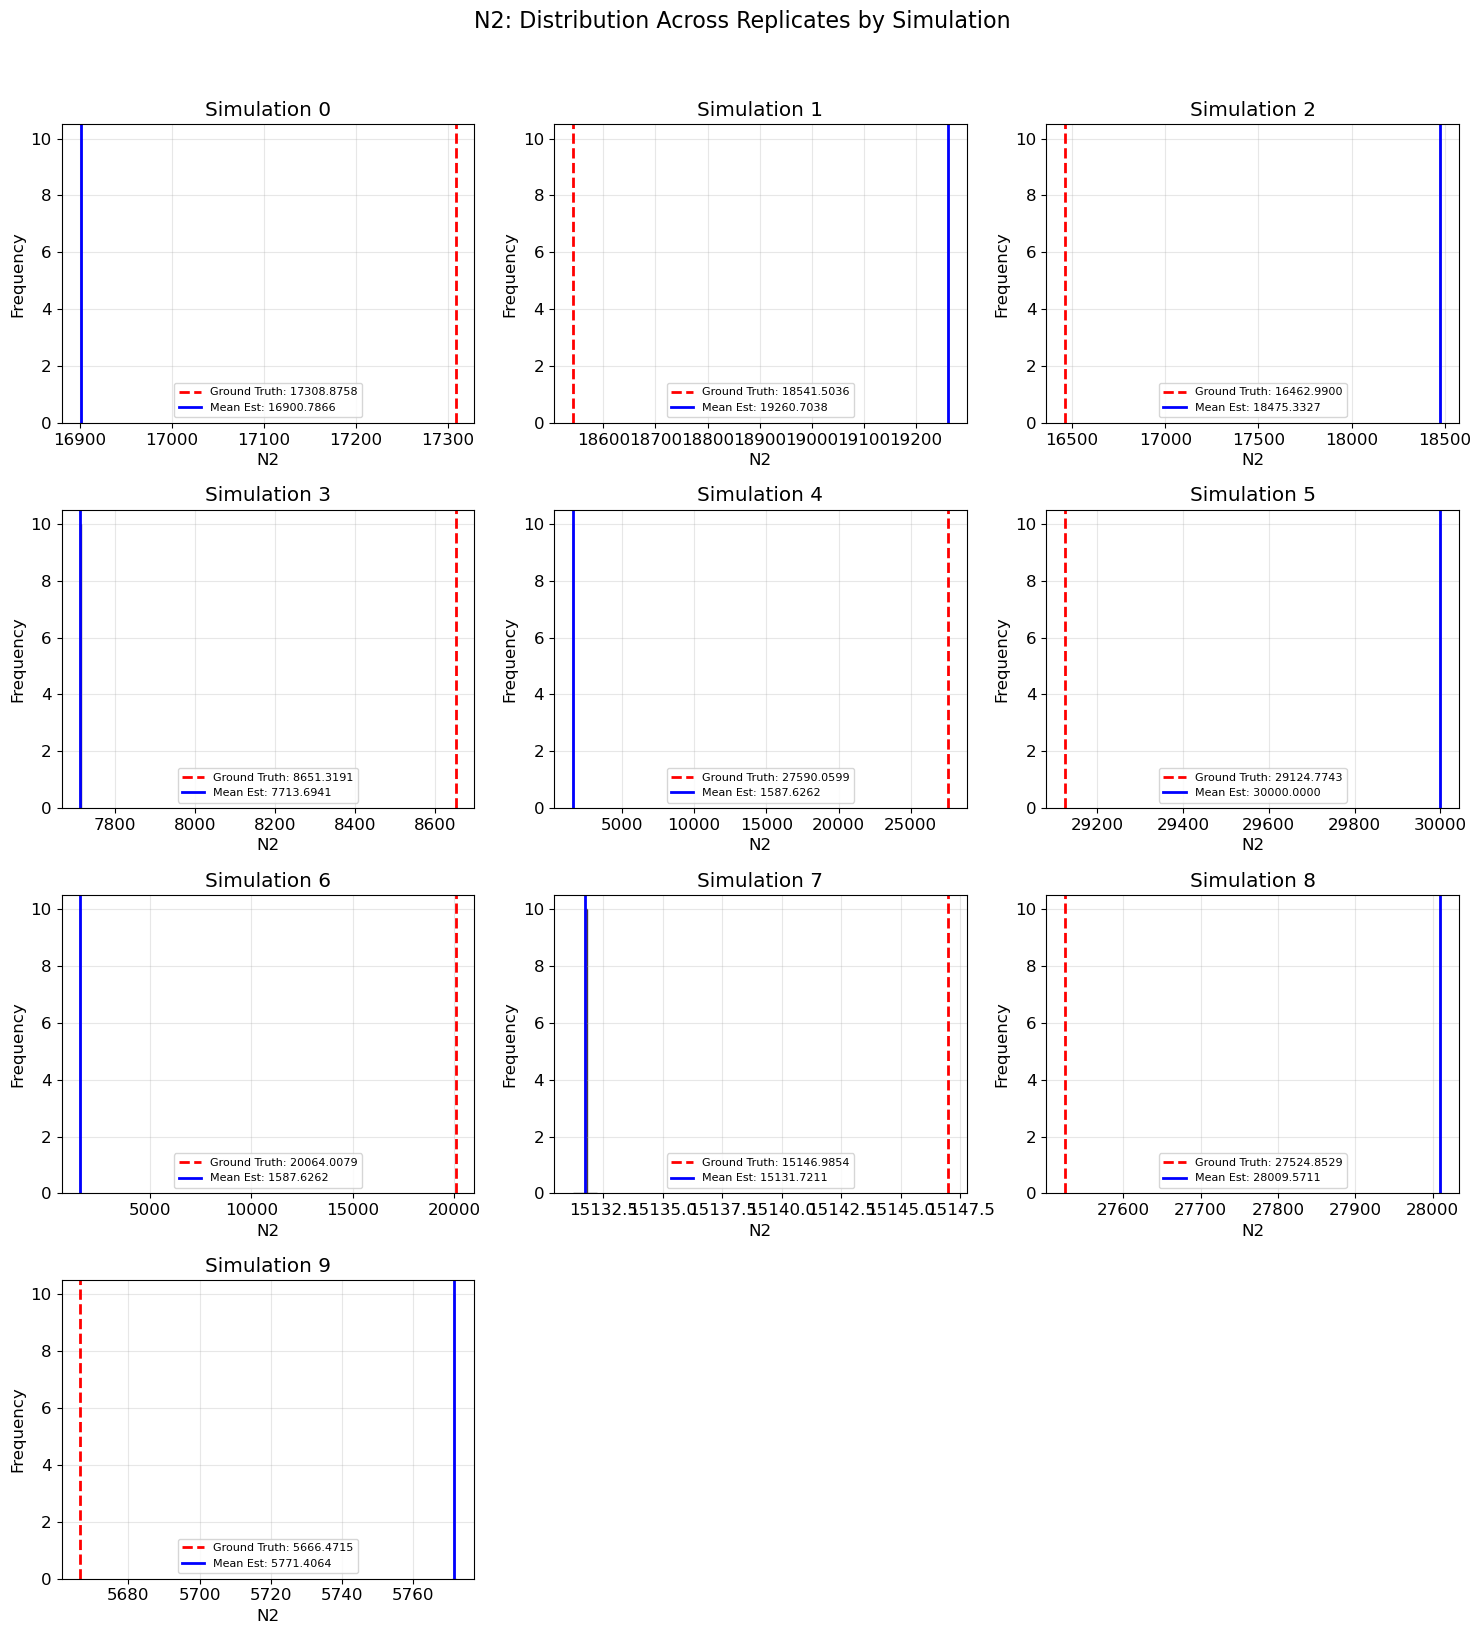

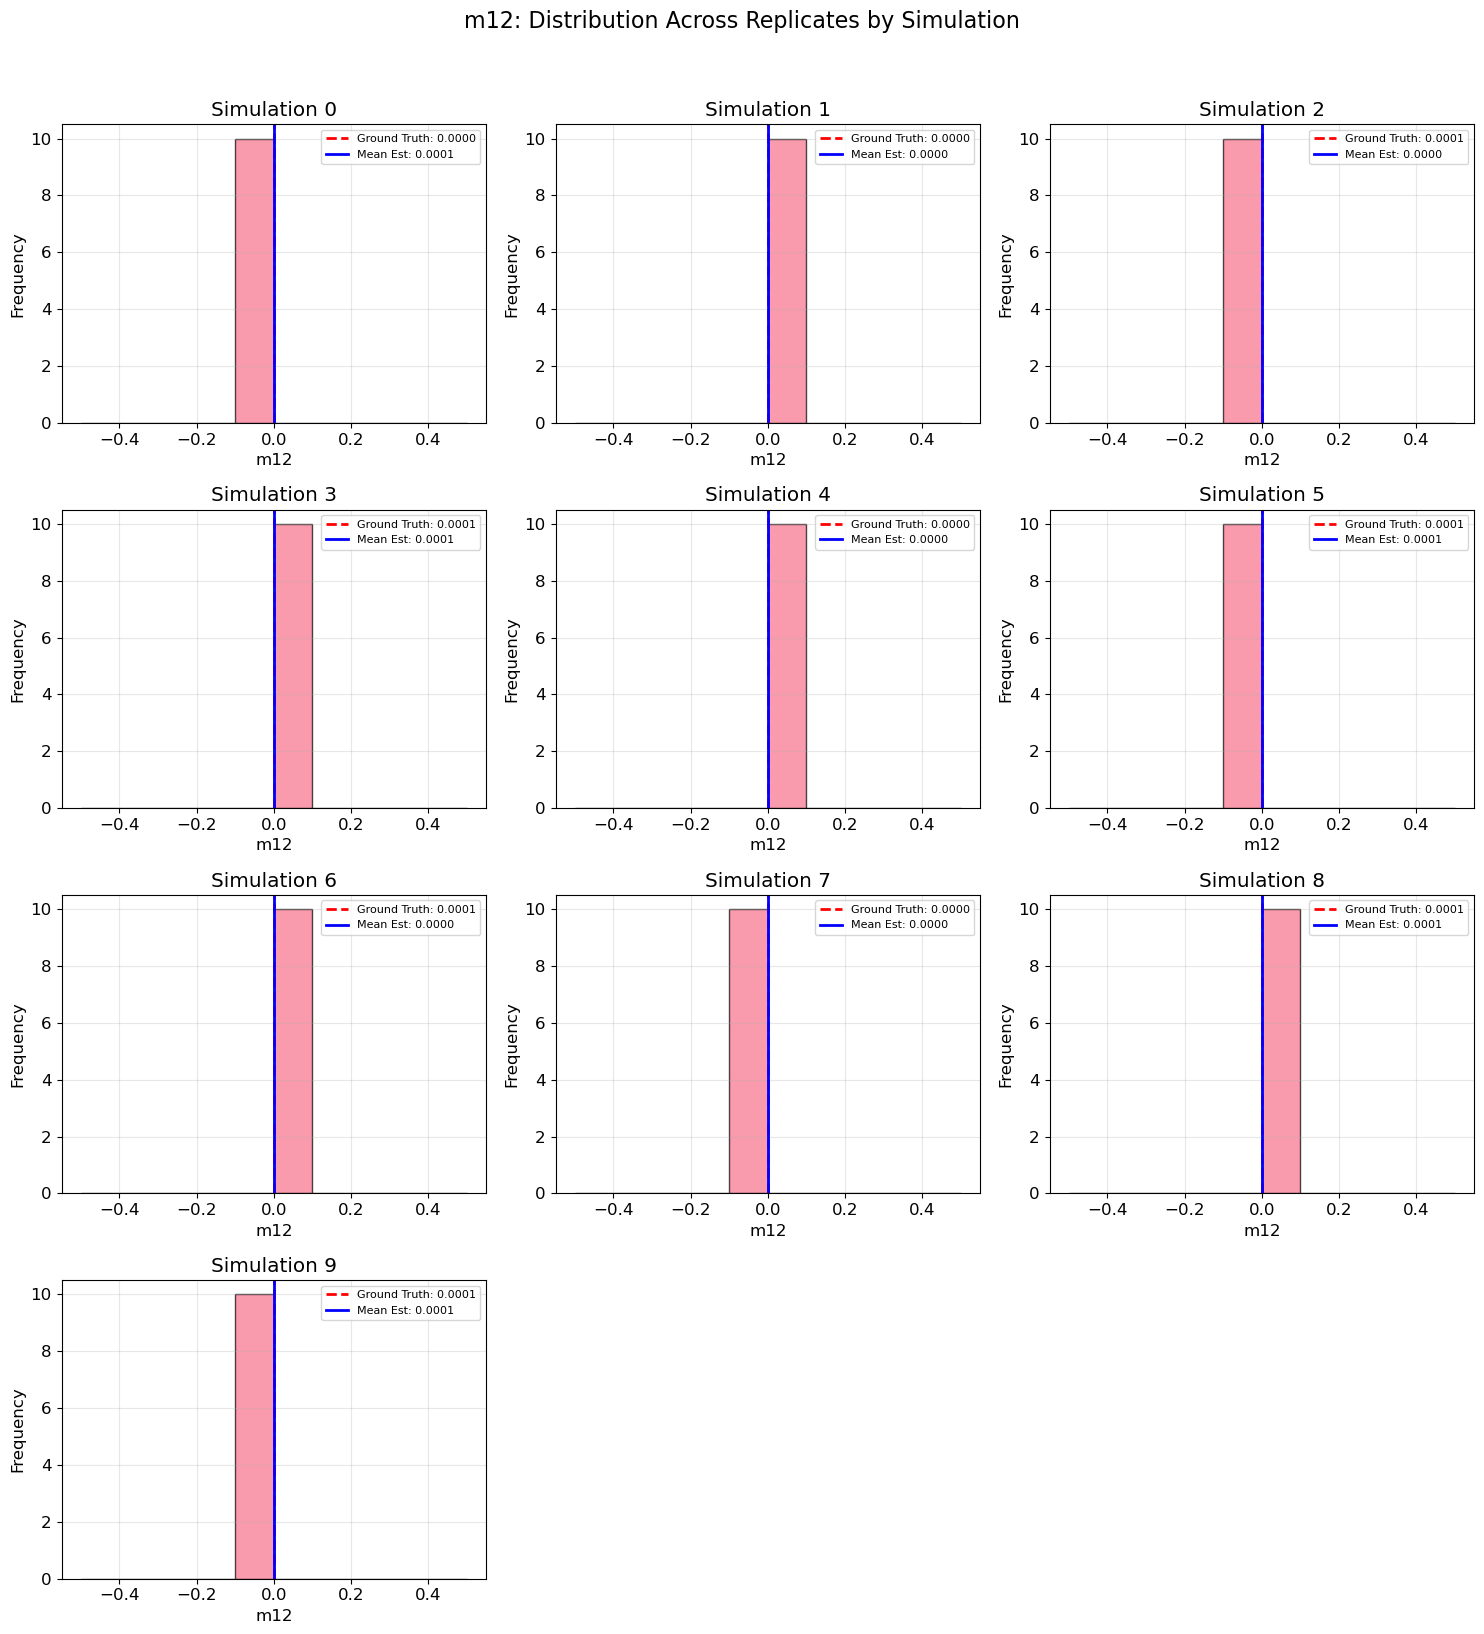

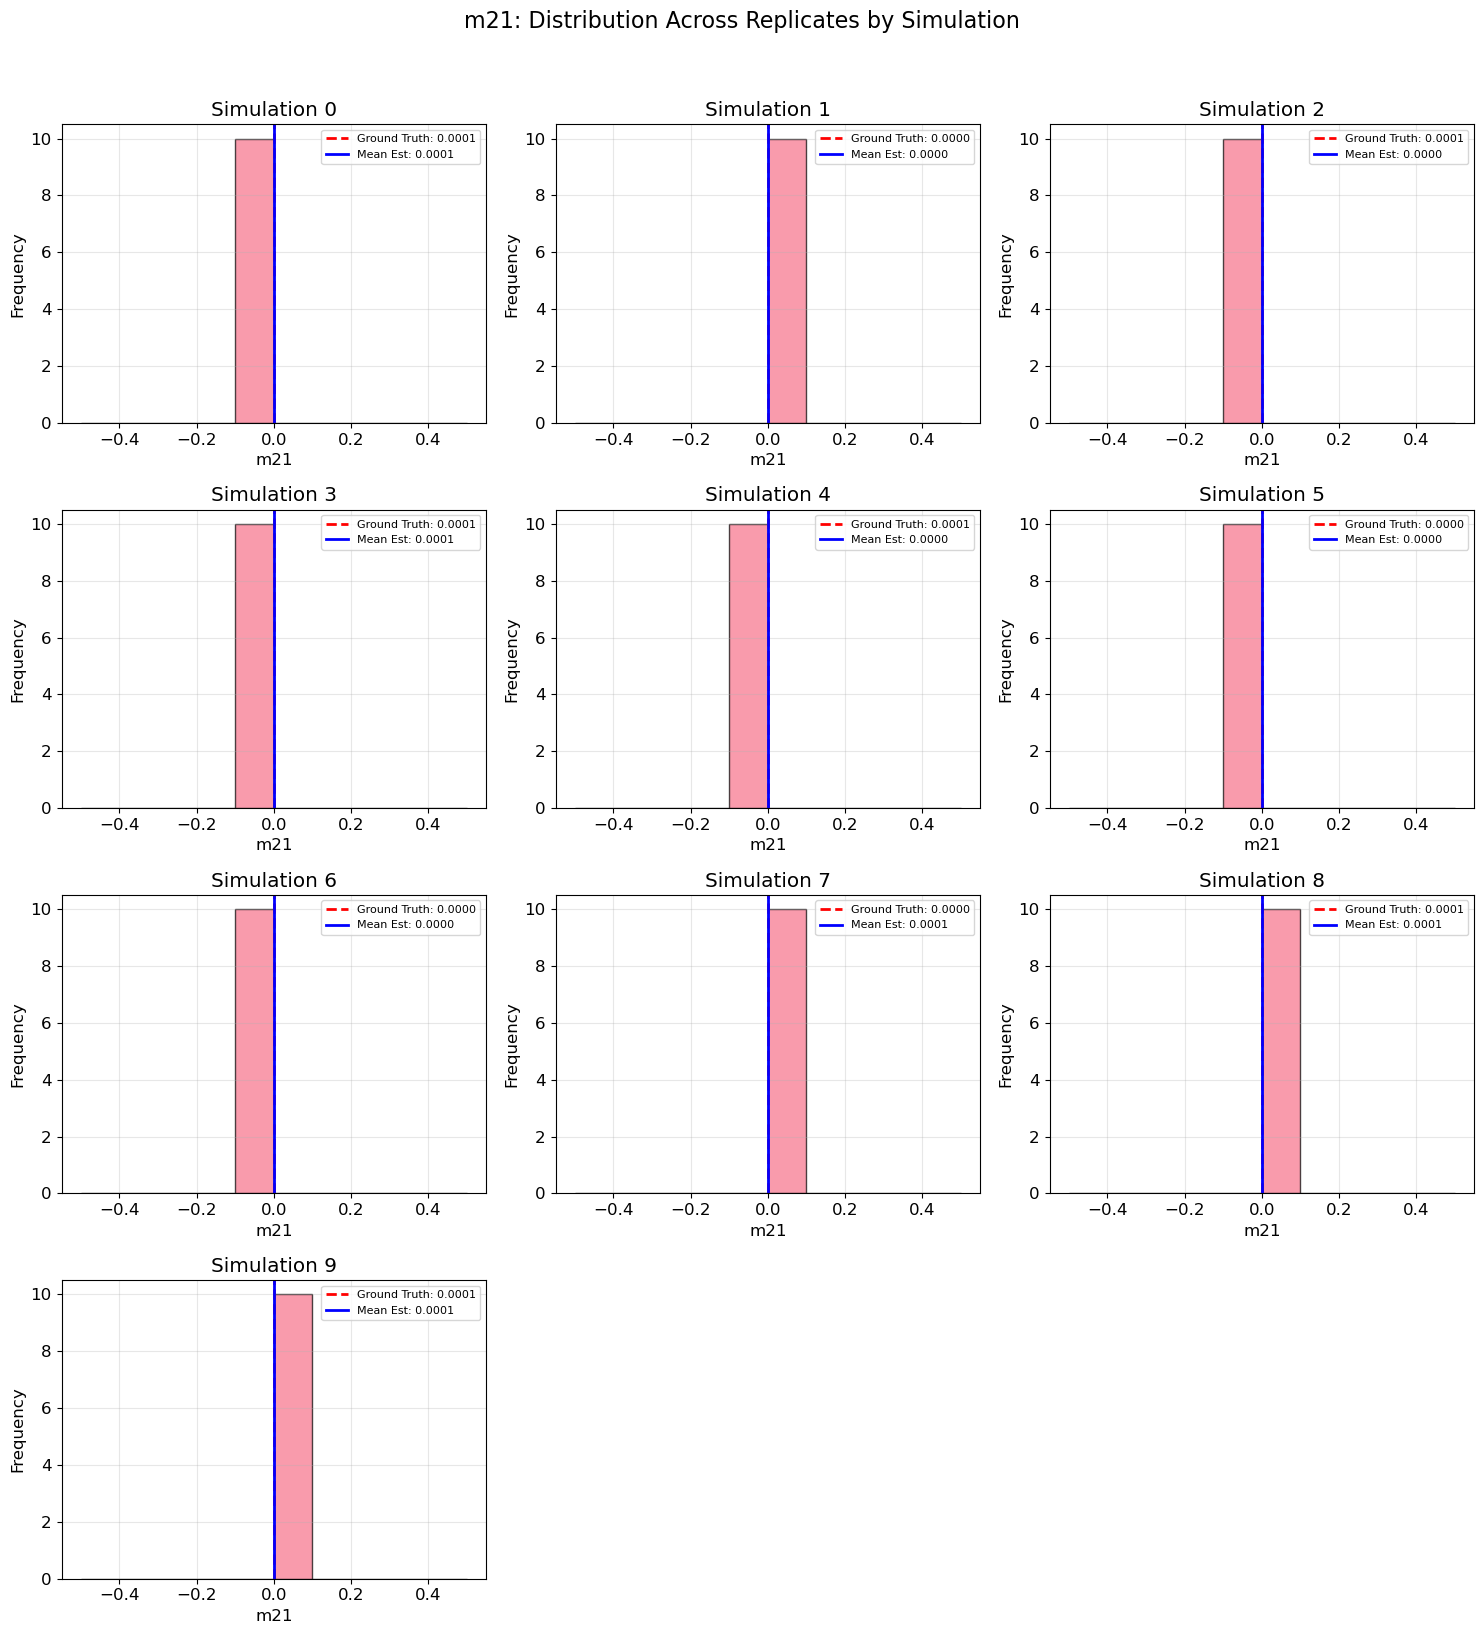

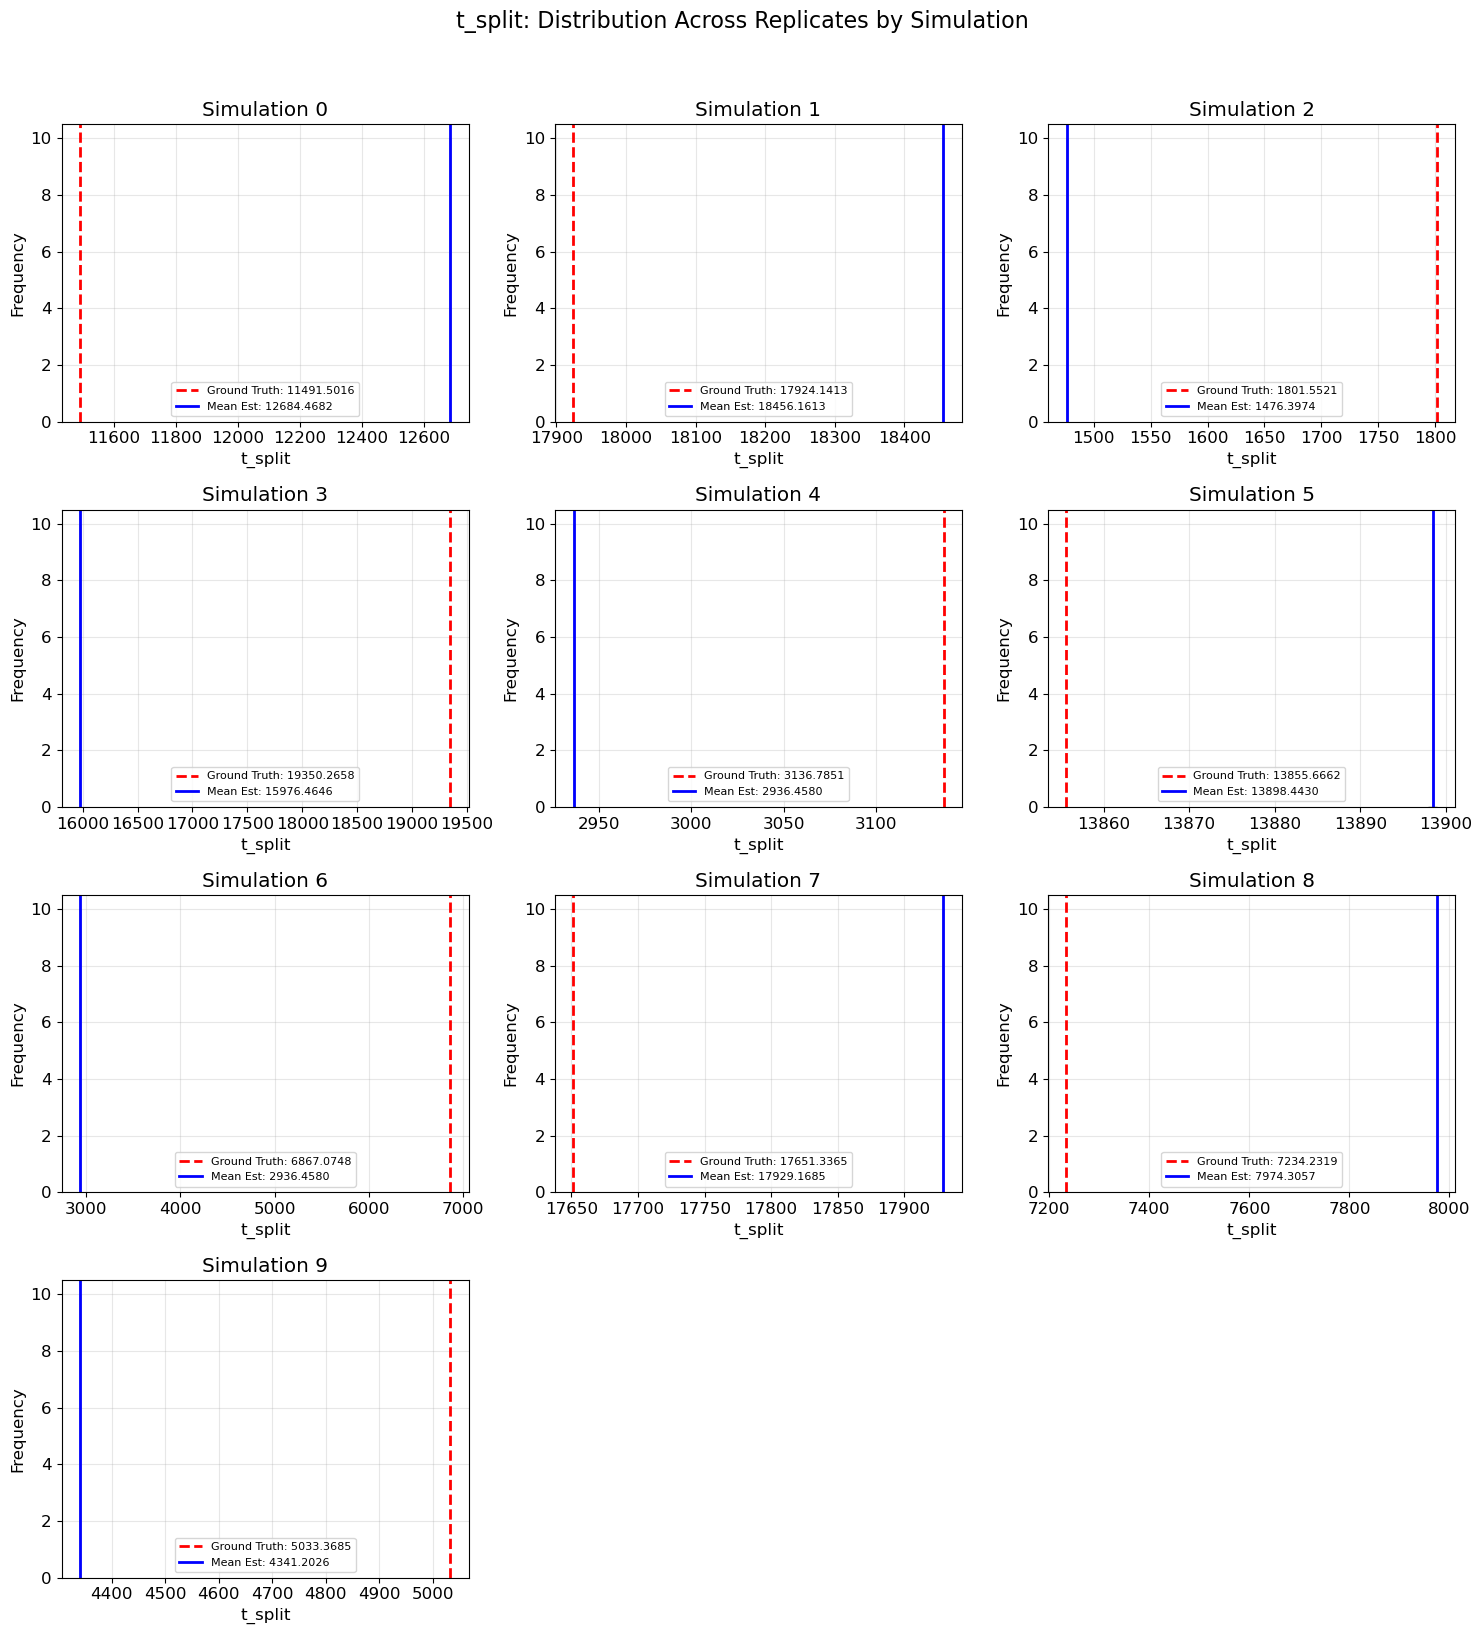

In [9]:
def plot_parameter_histograms_by_simulation(df, parameter_name):
    """Plot histograms of estimated parameters for each simulation."""
    param_data = df[df['parameter'] == parameter_name]
    
    if len(param_data) == 0:
        print(f"No data found for parameter {parameter_name}")
        return
    
    simulations = sorted(param_data['simulation'].unique())
    n_sims = len(simulations)
    
    # Create subplots
    cols = 3
    rows = (n_sims + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, sim_id in enumerate(simulations):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        
        sim_data = param_data[param_data['simulation'] == sim_id]
        
        # Plot histogram
        ax.hist(sim_data['estimated'], bins=10, alpha=0.7, edgecolor='black')
        
        # Add vertical line for ground truth
        gt_value = sim_data['ground_truth'].iloc[0]
        ax.axvline(gt_value, color='red', linestyle='--', linewidth=2, 
                  label=f'Ground Truth: {gt_value:.4f}')
        
        # Add vertical line for mean estimate
        mean_est = sim_data['estimated'].mean()
        ax.axvline(mean_est, color='blue', linestyle='-', linewidth=2,
                  label=f'Mean Est: {mean_est:.4f}')
        
        ax.set_title(f'Simulation {sim_id}')
        ax.set_xlabel(f'{parameter_name}')
        ax.set_ylabel('Frequency')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_sims, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].set_visible(False)
    
    plt.suptitle(f'{parameter_name}: Distribution Across Replicates by Simulation', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Create histograms for all parameters
if 'df_comparison' in locals() and not df_comparison.empty:
    for param in df_comparison['parameter'].unique():
        plot_parameter_histograms_by_simulation(df_comparison, param)
else:
    print("No comparison data available for plotting")

## Statistical Analysis of Parameter Estimates

Calculate summary statistics and assess bias and accuracy relative to ground truth.

Parameter Estimation Statistics:
   parameter simulation  ground_truth  mean_estimate  relative_bias  \
0         N0          0    18501.6315     18245.5571        -0.0138   
1         N0          1    13796.0931     13953.7523         0.0114   
2         N0          2    18423.0973     18956.2744         0.0289   
3         N0          3    24095.5231     24185.9055         0.0038   
4         N0          4    16788.5811      1502.1894        -0.9105   
5         N0          5     1008.0887      1081.6478         0.0730   
6         N0          6     5387.0582      1502.1894        -0.7211   
7         N0          7    11634.6301     11518.2927        -0.0100   
8         N0          8    20960.2230     20839.2747        -0.0058   
9         N0          9    24697.4839     25204.5569         0.0205   
10        N1          0    16024.4906     15561.3300        -0.0289   
11        N1          1    17835.2593     17837.2437         0.0001   
12        N1          2     9412.1869      9

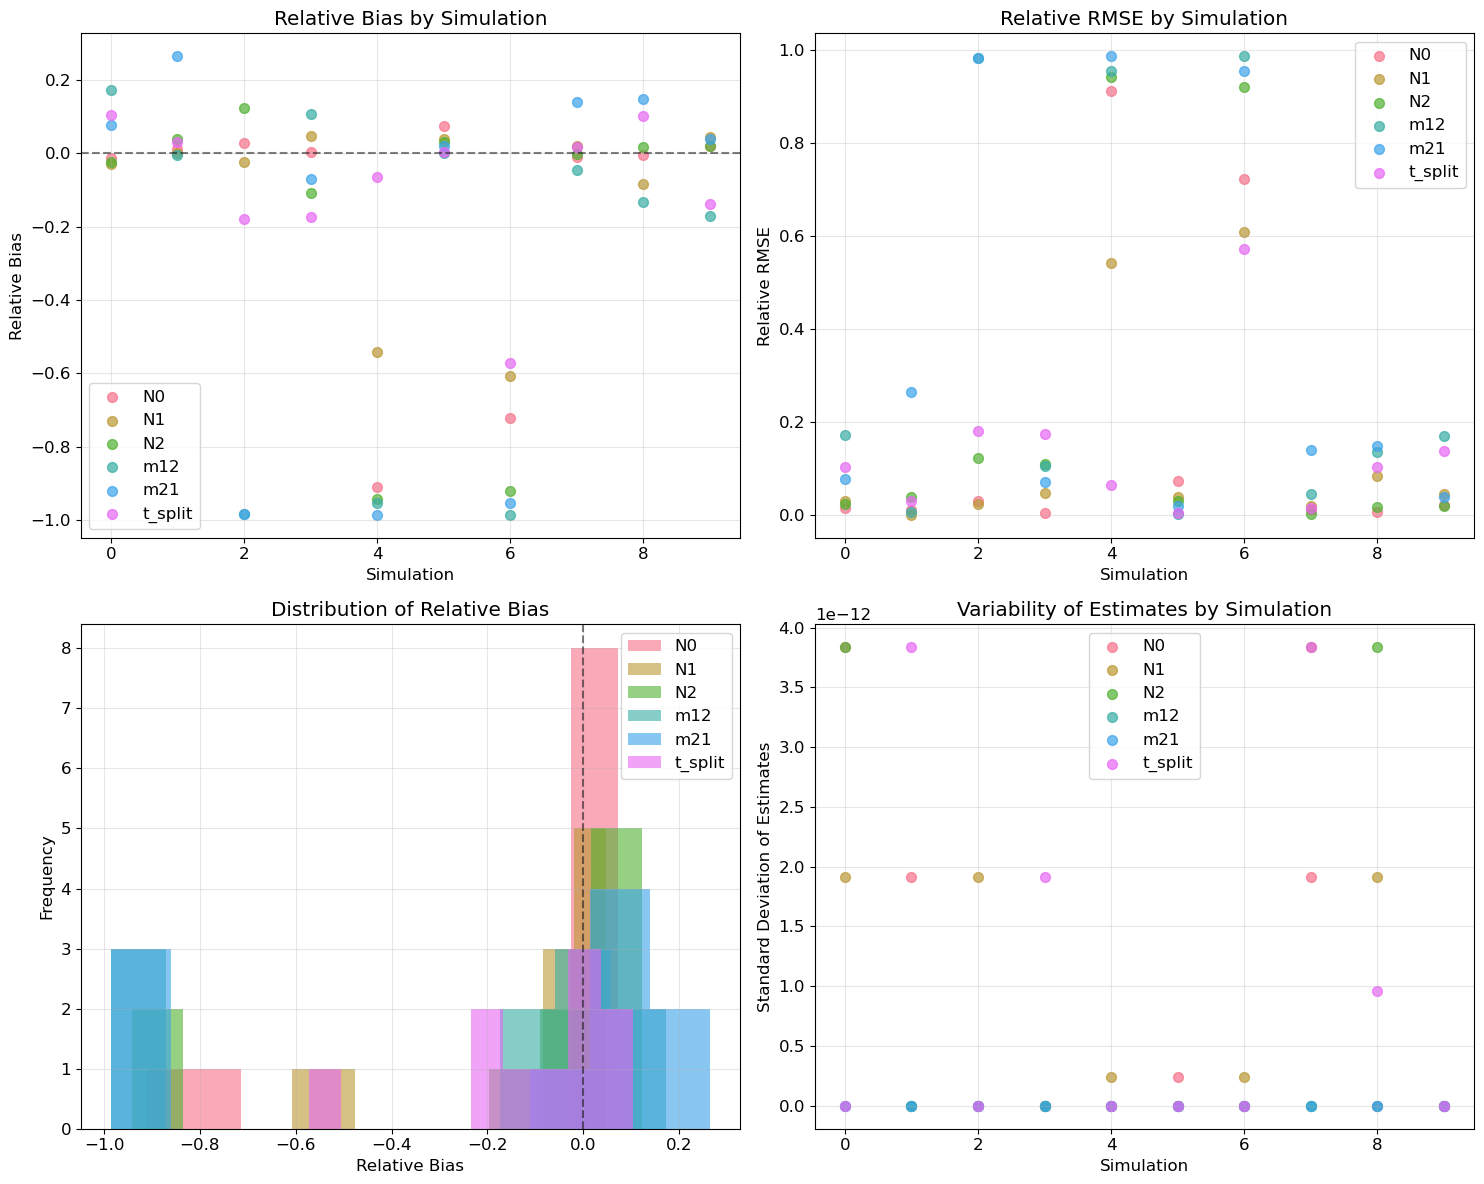



Overall Summary by Parameter:
          relative_bias         relative_rmse         n_replicates
                   mean     std          mean     std          sum
parameter                                                         
N0              -0.1524  0.3534        0.1799  0.3387          100
N1              -0.1136  0.2466        0.1432  0.2288          100
N2              -0.1769  0.4019        0.2223  0.3760          100
m12             -0.3001  0.4761        0.3560  0.4312          100
m21             -0.2307  0.5209        0.3680  0.4242          100
t_split         -0.0874  0.1999        0.1383  0.1649          100


In [10]:
def calculate_parameter_statistics(df):
    """Calculate comprehensive statistics for parameter estimates."""
    stats_results = []
    
    for param in df['parameter'].unique():
        param_data = df[df['parameter'] == param]
        
        for sim_id in param_data['simulation'].unique():
            sim_data = param_data[param_data['simulation'] == sim_id]
            
            gt_value = sim_data['ground_truth'].iloc[0]
            estimates = sim_data['estimated']
            
            # Calculate statistics
            stats_results.append({
                'parameter': param,
                'simulation': sim_id,
                'ground_truth': gt_value,
                'mean_estimate': estimates.mean(),
                'median_estimate': estimates.median(),
                'std_estimate': estimates.std(),
                'min_estimate': estimates.min(),
                'max_estimate': estimates.max(),
                'bias': estimates.mean() - gt_value,
                'relative_bias': (estimates.mean() - gt_value) / gt_value if gt_value != 0 else np.nan,
                'rmse': np.sqrt(((estimates - gt_value) ** 2).mean()),
                'relative_rmse': np.sqrt(((estimates - gt_value) ** 2).mean()) / abs(gt_value) if gt_value != 0 else np.nan,
                'coverage_95': np.sum((estimates >= np.percentile(estimates, 2.5)) & 
                                    (estimates <= np.percentile(estimates, 97.5))) / len(estimates),
                'n_replicates': len(estimates)
            })
    
    return pd.DataFrame(stats_results)

def plot_bias_analysis(stats_df):
    """Plot bias analysis across parameters and simulations."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Relative bias by parameter
    ax1 = axes[0, 0]
    for param in stats_df['parameter'].unique():
        param_stats = stats_df[stats_df['parameter'] == param]
        ax1.scatter(param_stats['simulation'].astype(int), param_stats['relative_bias'], 
                   label=param, alpha=0.7, s=50)
    ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Simulation')
    ax1.set_ylabel('Relative Bias')
    ax1.set_title('Relative Bias by Simulation')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # RMSE by parameter
    ax2 = axes[0, 1]
    for param in stats_df['parameter'].unique():
        param_stats = stats_df[stats_df['parameter'] == param]
        ax2.scatter(param_stats['simulation'].astype(int), param_stats['relative_rmse'], 
                   label=param, alpha=0.7, s=50)
    ax2.set_xlabel('Simulation')
    ax2.set_ylabel('Relative RMSE')
    ax2.set_title('Relative RMSE by Simulation')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Overall bias distribution
    ax3 = axes[1, 0]
    for param in stats_df['parameter'].unique():
        param_stats = stats_df[stats_df['parameter'] == param]
        ax3.hist(param_stats['relative_bias'].dropna(), alpha=0.6, label=param, bins=10)
    ax3.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Relative Bias')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Relative Bias')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Standard deviation of estimates
    ax4 = axes[1, 1]
    for param in stats_df['parameter'].unique():
        param_stats = stats_df[stats_df['parameter'] == param]
        ax4.scatter(param_stats['simulation'].astype(int), param_stats['std_estimate'], 
                   label=param, alpha=0.7, s=50)
    ax4.set_xlabel('Simulation')
    ax4.set_ylabel('Standard Deviation of Estimates')
    ax4.set_title('Variability of Estimates by Simulation')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Calculate and display statistics
if 'df_comparison' in locals() and not df_comparison.empty:
    stats_df = calculate_parameter_statistics(df_comparison)
    
    print("Parameter Estimation Statistics:")
    print("=" * 50)
    
    # Display summary table
    summary_cols = ['parameter', 'simulation', 'ground_truth', 'mean_estimate', 
                   'relative_bias', 'relative_rmse', 'n_replicates']
    print(stats_df[summary_cols].round(4))
    
    # Plot bias analysis
    plot_bias_analysis(stats_df)
    
    # Overall summary by parameter
    print("\n\nOverall Summary by Parameter:")
    print("=" * 40)
    overall_summary = stats_df.groupby('parameter').agg({
        'relative_bias': ['mean', 'std'],
        'relative_rmse': ['mean', 'std'],
        'n_replicates': 'sum'
    }).round(4)
    print(overall_summary)
    
else:
    print("No comparison data available for statistical analysis")

## Save Results

Save the comparison data and statistics for future reference.

In [ ]:
# Save results to CSV files
output_dir = Path('/home/akapoor/kernlab/Infer_Demography/notebooks/analysis_results')
output_dir.mkdir(exist_ok=True)

if 'df_comparison' in locals() and not df_comparison.empty:
    # Save comparison data
    comparison_file = output_dir / 'parameter_comparison.csv'
    df_comparison.to_csv(comparison_file, index=False)
    print(f"Saved comparison data to: {comparison_file}")
    
    # Save statistics
    if 'stats_df' in locals():
        stats_file = output_dir / 'parameter_statistics.csv'
        stats_df.to_csv(stats_file, index=False)
        print(f"Saved statistics to: {stats_file}")
    
    print(f"\nAnalysis complete! Results saved to {output_dir}")
else:
    print("No data to save - check data loading steps above")